# Ejecución de modelos RFSM con python


29/09/2021

**Salvador Navas Fernández** ([IH Cantabria](https://ihcantabria.com/), Santander, Spain)

<img src="https://ihcantabria.com/wp-content/uploads/2020/07/Logo-IHCantabria-Universidad-Cantabria-cmyk.png" alt="drawing" width="500"/>

En lo últimos años el avance de python y QGIS han permitido ir ganando terreno a ArcGIS cuya licencia no es libre. Por tanto en este trabajo se han realizado funciones que permiten realizar el trabajo en cualquier sistema operativo y de forma más optimizada y automática. El objetivo principal es el elaborar los inputs de partida del modelo RFSM y su ejecución, de esta forma se ha conseguido reducir lo tiempos de cómputo del proceso.

A continuación se muestra un ejemplo de principio a fin de cómo elaborar y proyecto de RFSM, su ejecución y la obtención de resultados.

In [1]:
from RFSM_python.impactzones import *
from RFSM_python.perfiles import *
from RFSM_python.manning import *
from RFSM_python.tursBC import *
from RFSM_python.executionRFSM import *

import warnings
warnings.filterwarnings('ignore')

# INPUT

En primer lugar es necesario configurar los nombres de los path donde se va a trabajar además de la configuración inicial del modelo RFSM.
Previamente se tiene que tener ya la carpeta configurada, es decir con la siguiente distribución de carpetas que se obtiene al ejecutar las siguientes líneas. 

```
project
└───ascii
└───bin
└───demos
└───doc
└───scripts
└───shp
└───src
└───test
```



In [6]:
path_project      = '../tests/MURCIA/RFSM/' # Directorio donde se va a localizar el proyecto, es decir donde se va a simular el modelo
COTA_ESTUDIO      = 10
cellsize          = 5
path_output       = path_project+'/ascii/'
DTM_CLIP_LC       = '../tests/MURCIA/DATA_IN/MDT/mdt.asc'
path_install_RFSM = '../tests/IHRFSM_v1.0/'

In [7]:
n_periods = 13

TestID = 1
TestDesc = 'Murcia_Malla_1'
BCSetID = 1
StartTime = '0#h'
EndTime = str(n_periods)+'#h'
TimeStep = 1
SaveTimeStep = '20#m'
MaxTimeStep = 20
MinTimeStep = 0.0001
AlphaParameter = 0.7
ManningGlobalValue = 0.035
Results = '1'
make_dirs(path_install_RFSM,path_project,TestDesc,Results)

Una vez creadas las carpetas Lo más importante es que las carpetas contengan los ficheros necesarios, lo más importante es la carpeta ascii de donde partiremos para preprar el modelo. En esta carpeta se deben de encontrar los ficheros que se crean tras la ejecución de 'AccData'.

```
project
└───ascii
│   │   floodareas.asc
│   │   tblCell.csv
│   │   tblImpactZone.csv
│   │   tblIZNbrWidth.csv
│   │   tblIZNeighbour.csv
│   │   tblIZVolume.csv
│   │   tblParameters.csv
│   │   topography.asc
│   └───check
│       │   acccells_izid.csv
│       │   cellid.asc
│       │   dirdrainage.asc
│       │   izid1.asc
│       │   izid2.asc
│───bin
│───demos
│───doc
│───scripts
│───shp
│───src
│───test
```


Una vez que se han obtenido la malla de proyecto de estudio, se procede a la ejecución del proceso para obtener los inputs necesarios del modelo RFSM

# IMPACT ZONES

In [4]:
Table_impact_zone, izcoast = impact_zones_process(path_project,DTM_CLIP_LC,cellsize=cellsize,COTA_ESTUDIO = COTA_ESTUDIO, new_coast_Line = True)

182.68986773490906


Una vez que se ha ejecutado la línea anterior se crean dentro de la carpeta **shp** y **ascii** ficheros importantes para la configuración del modelo RFSM
```
project
└───ascii
│   │   izcoast.csv
│   │   tblImpactZone.csv
└───shp
│   │  izcoast.shp
```

El fichero **izcoast.shp** son las ImpactZones donde se incoporan las condiciones de contorno asociadas a *nivel* o *rebase*, pero en ocasiones cuando el corte del mdt no es limpio se generan celdas de contorno que no son correctas, por tanto es necesario modificar eliminando estas celdas del fichero **izcoast.shp**. Al nuevo fichero creado le llamamos **izcoast_2.shp** Para modificar la tabla de *izcoast* Se ejecuta la siguiente línea de código obteniendo como resultado otro fichero csv llamado **izcoast_def.csv** que será utilizado para las condiciones de contorno de RFSM.

In [5]:
izcoast_modify(path_project,path_project+'shp/izcoast_2.shp', path_project+'ascii/izcoast.csv', path_project+'ascii/izcoast_def.csv')

# PERFILES BATIMETRÍA

Uno de los parámetros necesarios necesarios en las características de los puntos de TWL es la pendiente de la costa. Como datos de partida es necesaria una linea de costa y la batimetría. La batimetría puede ser utilizada como curvas de nivel o a través de un raster.

En este ejemplo se puede utilizar los dos formatos ya que se ha descargado la batimetría de la zona de estudio de la [Ecocartografía](https://www.miteco.gob.es/es/costas/temas/proteccion-costa/ecocartografias/default.aspx) y se ha generado un raster a partir de la interpolación de las curvas de nivel. Es necesario destacar que la descarga de la Batimetría de la Ecocartografía es en formato KML por lo que a través de QGIS es necesario exportarla a shape ya que la cota no está asignada a la geometría sino que está fuera.

Los parámetros que se introducen son:
* SPAC = que es la separación que se quiere entre perfiles
* Ltierra = longitud del perfil desde la linea de costa hacia tierra
* Lmar = longitud del perfil hacia el mar. Siempre el perfil tiene que superar el punto de dinámicas
* Postierra = **1** Si en el sentido de avance de la línea de costa la tierra está a la izquierda **0** Si en el sentido de avance de la línea de costa la tierra está a la derecha
* plott = **1** si se quiere plotear los perfiles y **0** si no se quiere

Una vez que se generan los perfiles es necesario editarlo en GIS para evitar que se crucen o que haya perfiles fuera de la batimetría. También en ocasiones cuando se utilizan curvas de nivel es necesario verificar que todos los perfiles cruzan las curvas de nivel. Sino sería necesario editarlo también.


In [2]:
SPAC = 800
Ltierra = 200
Lmar = 1000
Postierra = 0
plott = 1
EPSG  = 25830

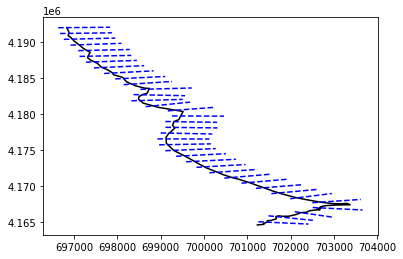

In [3]:
traza_perfiles_linea('../tests/MURCIA/DATA_IN/Perfiles/linea_costa_suavizada.shp',
                     SPAC,Ltierra,Lmar,Postierra,plott,path_output='../tests/MURCIA/DATA_IN/Perfiles/')

Una vez modificado el shape de perfiles llamado **Cross_Sections.shp** se jecuta la siguiente línea para actualizar la tabla de atributos y generar el fichero de perfiles final **Cross_Sections_Final.shp**

In [4]:
correct_perfiles_linea('../tests/MURCIA/DATA_IN/Perfiles/Cross_Sections.shp',path_output='../tests/MURCIA/DATA_IN/Perfiles/')

A continuación se calcula la pendiente para cada uno de los perfiles y se obtiene el fichero **Cross_Sections_mforshore**.

In [4]:
calculate_mforshore('../tests/MURCIA/DATA_IN/Batimetria/Batimetria.tif', 
                    '../tests/MURCIA/DATA_IN/Perfiles/Cross_Sections_Final.shp', EPSG, '../tests/MURCIA/DATA_IN/Perfiles/')

Una vez calculada la pendiente de los perfiles, a cada punto de TWL (**puntos_TWL.shp**) se le asigna la pendiente del perfil más cercano.

In [4]:
update_mforeshore_TWL('../tests/MURCIA/DATA_IN/Perfiles/Cross_Sections_mforshore.shp',
                      '../tests/MURCIA/DATA_IN/TWL/puntos_TWL.shp',25830,
                      '../tests/MURCIA/DATA_IN/TWL/')

# DINÁMICAS

In [128]:
Table_impact_zone=pd.read_csv(path_project+'ascii/tblImpactZone.csv',index_col=0)
izcoast=pd.read_csv(path_project+'ascii/izcoast.csv',index_col=0)

###  LEVEL IN A SERIES OF POINTS ALONG THE COAST

In [131]:
tusrBCFlowLevel (path_project,TestDesc,Table_impact_zone,izcoast,BCSetID,BCTypeID_COAST,
                    CF_FV,xD,yD,CM,CI_pleamar, n_periods,input_=2)

100%|███████████████████████████████████████████████████████████████████████████████| 590/590 [00:03<00:00, 161.73it/s]


## Manning

In [132]:
create_file_manning(path_project,'F:/PIMA_ADAPTA_MURCIA/GIS/rugosidad',TestDesc,Table_impact_zone)

100%|███████████████████████████████████████████████████████████████████████████| 23983/23983 [03:25<00:00, 116.69it/s]


## Create XML

In [133]:
create_xml(TestID,TestDesc,BCSetID,StartTime,EndTime,TimeStep,SaveTimeStep,MaxTimeStep,MinTimeStep,AlphaParameter,ManningGlobalValue,path_project,Results)

## Ejecución 

In [134]:
execute_RFSM(path_project,TestDesc,TestID)

Assuming windows!


## Leer y exportar resultados

In [135]:
export_result_RFSM(path_project,TestDesc,Results)

100%|██████████████████████████████████████████████████████████████████████████| 23983/23983 [00:19<00:00, 1228.62it/s]
